 # Project Overview

This capstone project implements a data-driven system to optimize inventory management. It replaces static, rule-based reordering policies with a dynamic, predictive engine that forecasts future demand and calculates the optimal Reorder Point (ROP) and Reorder Quantity (ROQ) for each product.

The goal is to minimize total inventory costs by balancing the reduction of costly stockouts (lost sales) against the minimization of expensive holding costs (storage, capital tied up).

# 1. Import Libraries

In [83]:
# Install Statsmodels
#! pip install statsmodels

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

import time
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# 2. Load Data

In [126]:
data = pd.read_csv('retail_store_inventory.csv')
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [127]:
#check the columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

- No missing values in my data

In [128]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

# 3. Data Preparation and Feature Engineering

In [129]:
# Convert 'Date' to datetime and create 'SKU_Compound_ID'
data['Date'] = pd.to_datetime(data['Date'])
data['SKU_Compound_ID'] = data['Store ID'] + '_'+ data['Product ID']

In [130]:
data.sort_values(by = ['SKU_Compound_ID', 'Date'], inplace=True)

In [131]:
# Define Inventory Constants
ORDERING_COST = 50.0  # Cost to place an order
HOLDING_COST_PER_UNIT_YEAR = 5.0  # Annual holding cost per unit
STOCKOUT_COST = 10.0 # Cost per unit of unmet demand
DAYS_IN_YEAR = 365.0
SERVICE_LEVEL = 1.645  # Desired service level (95%)
LEAD_TIME_DAYS = 7  # Standard  lead time in days

Logistics and Inventory Management parameters
1. Lead time - How long it takes from placing an order with the supplier until the goods arrive.
2. Holding (carrying) cost - Rep the expense of keeping inventory in storage. This includes warehouse, depreciation, insurance and opportunity cost of capital
3. Ordering Cost - the fixed cost of placing one order, regardless of quantity. This includes administrative work, shipping, handling, and setup.
4. Service Level - is the probability of not running out of stock during the lead time.
5. Z-score (from the normal distribution) helps calculate safety stock. 

      Safety Stock = Z x std demand x square root of Lead time

  So, a Z = 1.645 gives a 95% confidence that demand during lead time will be covered.

In [132]:
# Add daily Holding Cost to base data for cost calculations
data['Daily_Holding_Cost'] = HOLDING_COST_PER_UNIT_YEAR / DAYS_IN_YEAR


EDA: Check for seasonality on aggregate demand

In [ ]:
#Aggregate daily demand across all SKUs to check for seasonality
daily_demand = data.groupby('Date')['Units Sold'].sum().reset_index()

In [92]:
# Lagged Demand 
data['demand_lag_7'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(7)
data['demand_lag_14'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(14)
data['demand_lag_30'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(30)
data['demand_lag_90'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(90)

In [95]:
# Time based Features
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfMonth'] = data['Date'].dt.day    
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

### Encoding

In [97]:
# Use Label Encoding for 'SKU_Compound_ID'
le = LabelEncoder()
data['SKU_Compound_ID_Encoded'] = le.fit_transform(data['SKU_Compound_ID']) 

In [98]:
# check for the categorical variables
data.select_dtypes(include=['object']).columns

Index(['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition',
       'Seasonality', 'SKU_Compound_ID'],
      dtype='object')

In [99]:
# One Hot Encoding for other categorical variables
data = pd.get_dummies(data, columns=['Category', 'Region', 'Weather Condition', 'Seasonality'], drop_first=True)

In [100]:
#data.info()# Drop the NaN values resulted from lagged and rolling features
data.dropna(inplace=True)

In [101]:
data.head()

,Date,Store ID,Product ID,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,...,Category_Toys,Region_North,Region_South,Region_West,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
9000,2022-04-01,S001,P0001,215,101,65,102.74,44.62,0,1,...,False,False,False,True,False,False,False,False,True,False
9100,2022-04-02,S001,P0001,200,70,54,74.21,81.11,15,1,...,False,False,False,False,False,False,True,False,False,True
9200,2022-04-03,S001,P0001,208,32,142,42.34,51.04,15,0,...,True,False,True,False,False,True,False,False,True,False
9300,2022-04-04,S001,P0001,70,54,197,60.25,70.04,10,1,...,False,True,False,False,False,False,True,False,True,False
9400,2022-04-05,S001,P0001,309,165,105,176.64,90.24,10,0,...,False,False,False,False,False,True,False,False,False,True


# 3. DEMAND FORECASTING ENGINE

3.1  Define Target and split Date

In [102]:
# check all columns 
data.columns


Index(['Date', 'Store ID', 'Product ID', 'Inventory Level', 'Units Sold',
       'Units Ordered', 'Demand Forecast', 'Price', 'Discount',
       'Holiday/Promotion', 'Competitor Pricing', 'SKU_Compound_ID',
       'demand_lag_7', 'demand_lag_14', 'demand_lag_30', 'demand_lag_90',
       'RollingStd_90', 'DayOfWeek', 'DayOfMonth', 'Month', 'Quarter', 'Year',
       'Lead_Time_Days', 'Holding_Cost_H', 'Ordering_Cost_S',
       'Service_Level_Z', 'SKU_Compound_ID_Encoded', 'Category_Electronics',
       'Category_Furniture', 'Category_Groceries', 'Category_Toys',
       'Region_North', 'Region_South', 'Region_West',
       'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter'],
      dtype='object')

In [103]:
TARGET = 'Units Sold'

# Columns to ignore (non-predictive or not needed for training)
IGNORE_COLS = [
    'Date', 'Store ID', 'Product ID', 'SKU_Compound_ID',
    'Units Ordered', 'Demand Forecast',
    'Lead_Time_Days', 'Holding_Cost_H', 'Ordering_Cost_S', 'Service_Level_Z'
]

# Select all feature columns that are not ignored and not the target
FEATURES = [col for col in data.columns if col not in IGNORE_COLS and col != TARGET]

# Sort data by date before splitting
data = data.sort_values('Date').reset_index(drop=True)

# Time based split: Use 90% for training, 10% for testing
split_date = data['Date'].quantile(0.9)

#Split the data  into training (past) and testing (future) subsets.
train_data = data[data['Date'] <= split_date]
test_data = data[data['Date'] > split_date]

# Redefine X and y for train and test sets based on the time split
X_train, y_train  = train_data[FEATURES], train_data[TARGET]
X_test, y_test = test_data[FEATURES], test_data[TARGET]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Training Period Ends: {split_date.date()}")


Training samples: 57700, Testing samples: 6400
Training Period Ends: 2023-10-29


 INSIGHTS
- In forecasting or time- series problems, random splitting (like in normal regression) would leak future information into the training set.

- Now by splitting chronologically, the model learns from the past, predicts the future and gets evaluated realistically(like how it would perform in production)

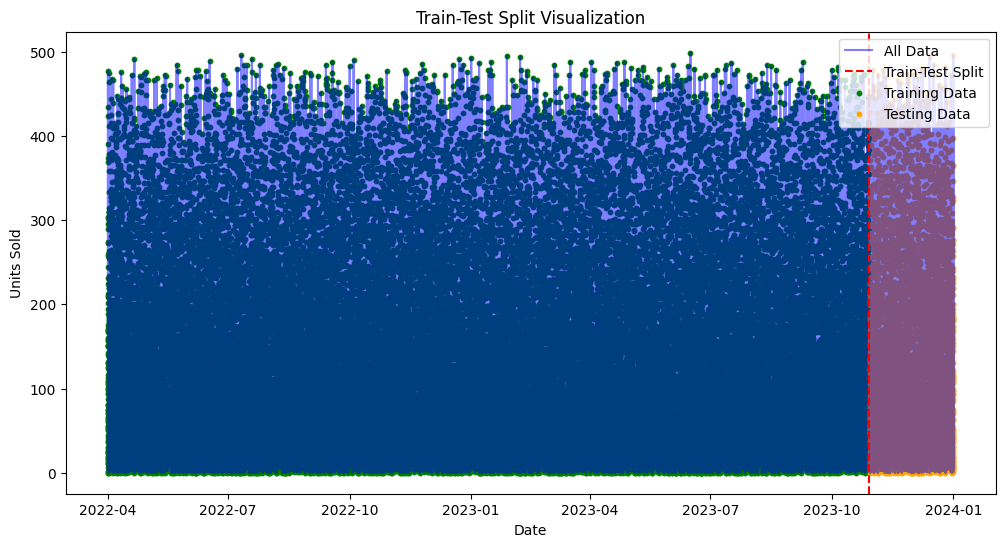

In [104]:
# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Units Sold'], label='All Data', color='blue', alpha=0.5)
plt.axvline(x=split_date, color='red', linestyle='--', label='Train-Test Split')
plt.scatter(train_data['Date'], train_data['Units Sold'], color='green', label='Training Data', s=10)
plt.scatter(test_data['Date'], test_data['Units Sold'], color='orange', label='Testing Data', s=10)
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.show()

3.2 Model Training (Random Forest)

In [105]:
# Training the Random Forest Regressor
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Random Forest model trained in {training_time:.2f} seconds.")

Random Forest model trained in 40.87 seconds.


For the depth, I have increased depth slightly for better pattern capture.

3.3 Model Evaluation Metrics

In [106]:
# Lets evaluate the model performance on the test set
y_pred = rf_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)  # Demand cannot be negative

In [107]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on Test Set: {mae:.2f} units")

Mean Absolute Error (MAE) on Test Set: 69.37 units


In [108]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.2f}units")

Root Mean Squared Error (RMSE) on Test Set: 88.66units


In [109]:
# MAPE calculation (handle zero actuals by using a small epsilon to avoid division by zero)
epsilon = 1e-10
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) on Test Set: 395033478405.58%


3.4 Future Demand Predictions per SKU

In [110]:
# Select the latest data point per SKU for future demand prediction
last_observation_data = data.sort_values('Date').groupby('SKU_Compound_ID').last().reset_index()

# prepare the features for prediction(same features,same order as training)
X_future_template = last_observation_data[FEATURES]

# Predict next period demand for each SKU using the trained model
last_observation_data['Forecasted_Demand_1_Period'] = rf_model.predict(X_future_template)


print(last_observation_data.columns.tolist())


['SKU_Compound_ID', 'Date', 'Store ID', 'Product ID', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'demand_lag_7', 'demand_lag_14', 'demand_lag_30', 'demand_lag_90', 'RollingStd_90', 'DayOfWeek', 'DayOfMonth', 'Month', 'Quarter', 'Year', 'Lead_Time_Days', 'Holding_Cost_H', 'Ordering_Cost_S', 'Service_Level_Z', 'SKU_Compound_ID_Encoded', 'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter', 'Forecasted_Demand_1_Period']


In [111]:
# Prepare the final forecast output
future_forecast_data = last_observation_data[['SKU_Compound_ID', 'Forecasted_Demand_1_Period','RollingStd_90', 'Lead_Time_Days', 'Service_Level_Z']]. copy()

# calculate total expected demand during lead time
future_forecast_data['Mean_Demand_Lead_Time'] = (future_forecast_data['Forecasted_Demand_1_Period'] * future_forecast_data['Lead_Time_Days'])

# calculate safety stock
future_forecast_data['Safety_Stock'] = (future_forecast_data['Service_Level_Z'] * future_forecast_data['RollingStd_90'] * np.sqrt(future_forecast_data['Lead_Time_Days']))

# calculate reorder point
future_forecast_data['Reorder_Point'] = future_forecast_data['Mean_Demand_Lead_Time'] + future_forecast_data['Safety_Stock']

# Display the future demand forecast with reorder points
future_forecast_data[['SKU_Compound_ID', 'Forecasted_Demand_1_Period', 'Reorder_Point']].head(10)


,SKU_Compound_ID,Forecasted_Demand_1_Period,Reorder_Point
0,S001_P0001,103.051778,995.060746
1,S001_P0002,113.018404,1055.995102
2,S001_P0003,33.001514,494.769455
3,S001_P0004,163.035235,1426.746108
4,S001_P0005,220.213015,1804.812225
5,S001_P0006,151.699339,1321.360448
6,S001_P0007,134.228947,1190.342118
7,S001_P0008,160.173791,1402.717807
8,S001_P0009,75.539007,795.006330
9,S001_P0010,75.515020,800.546525


In [112]:
# Rename and clean up columns for better readability
future_forecast_data.rename(columns={'RollingStd_90': 'Last_Observed_Sigma'}, inplace=True)
future_forecast_data = future_forecast_data.drop(columns=['Forecasted_Demand_1_Period'])

# Diplay the results
future_forecast_data.head(10)

,SKU_Compound_ID,Last_Observed_Sigma,Lead_Time_Days,Service_Level_Z,Mean_Demand_Lead_Time,Safety_Stock,Reorder_Point
0,S001_P0001,108.892879,7,0.95,721.362443,273.698303,995.060746
1,S001_P0002,105.378991,7,0.95,791.128829,264.866273,1055.995102
2,S001_P0003,104.938398,7,0.95,231.010595,263.758859,494.769455
3,S001_P0004,113.588057,7,0.95,1141.246645,285.499463,1426.746108
4,S001_P0005,104.764240,7,0.95,1541.491105,263.321120,1804.812225
5,S001_P0006,103.230086,7,0.95,1061.895370,259.465077,1321.360448
6,S001_P0007,99.758545,7,0.95,939.602632,250.739486,1190.342118
7,S001_P0008,111.997348,7,0.95,1121.216535,281.501273,1402.717807
8,S001_P0009,105.922864,7,0.95,528.773052,266.233278,795.006330
9,S001_P0010,108.193875,7,0.95,528.605142,271.941383,800.546525


# Inventory Optimization 

On this step we are going to calculate the optimal ROP (when to reorder) and ROQ (How much to reorder ) using classic inventory theory and then simulates how this optimized (“Dynamic”) policy compares to a traditional (“Static”) policy in terms of total cost (ordering, holding, stockouts).

3.1 Define Inventory Costs

In [113]:
ORDERING_COST = 50.0  # per order
HOLDING_COST_PER_UNIT_YEAR = 5.0  #nnual cost to hold one item in stock (rent, insurance, spoilage, etc.).
STOCKOUT_COST = 10.0  # per unit when you run out (lost profit + customer dissatisfaction).
DAYS_IN_YEAR = 365

data['Holding_Cost_Day'] = HOLDING_COST_PER_UNIT_YEAR / DAYS_IN_YEAR
future_forecast_data['Holding_Cost_Day'] = HOLDING_COST_PER_UNIT_YEAR / DAYS_IN_YEAR
#future_forecast_data['Ordering_Cost'] = ORDERING_COST

4.2 Calculate Dynamic ROP and ROQ

In [114]:
## Safety Stock (SS): SS = Z-score * Demand Variability over Lead Time (Sigma_L)
# Sigma_L = Last_Observed_Sigma * sqrt(Lead_Time)
future_forecast_data['Sigma_L'] = future_forecast_data['Last_Observed_Sigma'] * np.sqrt(future_forecast_data['Lead_Time_Days'])
future_forecast_data['Safety_Stock'] = future_forecast_data['Service_Level_Z'] * future_forecast_data['Sigma_L']

# Extra Inventory to cushion demand spikes

In [115]:
# ROP = Mean_Demand_Lead_Time + Safety_Stock
future_forecast_data['Dynamic_ROP'] = (future_forecast_data['Mean_Demand_Lead_Time'] + future_forecast_data['Safety_Stock'])
future_forecast_data['Dynamic_ROP'] = future_forecast_data['Dynamic_ROP'].round(0)
# Basically the reorder point adjusted dynamically based on demand variability and service level. When inventory drops to this level, it's time to reorder.

In [116]:
# Annual Demand - Scales the short-term (lead-time) demand up to an annual equivalent for EOQ formula.
future_forecast_data['Estimated_Annual_Demand'] = (future_forecast_data['Mean_Demand_Lead_Time'] * (DAYS_IN_YEAR / future_forecast_data['Lead_Time_Days']))

In [117]:
# Reorder Quantity (ROQ) using EOQ formula
future_forecast_data['Dynamic_ROQ'] = np.sqrt((2 * future_forecast_data['Estimated_Annual_Demand'] * ORDERING_COST) / HOLDING_COST_PER_UNIT_YEAR)
future_forecast_data ['Dynamic_ROQ'] = future_forecast_data['Dynamic_ROQ'].round(0)
# this code basically balances ordering and holding costs to find the optimal order quantity that minimizes total inventory costs.

In [118]:
# Final Output (The Reordering Policy)
reorder_policy_df = future_forecast_data[['SKU_Compound_ID', 'Dynamic_ROP', 'Dynamic_ROQ', 'Safety_Stock', 'Estimated_Annual_Demand']].copy()
print(reorder_policy_df.head())

  SKU_Compound_ID  Dynamic_ROP  Dynamic_ROQ  Safety_Stock  \
0      S001_P0001        995.0        867.0    273.698303   
1      S001_P0002       1056.0        908.0    264.866273   
2      S001_P0003        495.0        491.0    263.758859   
3      S001_P0004       1427.0       1091.0    285.499463   
4      S001_P0005       1805.0       1268.0    263.321120   

   Estimated_Annual_Demand  
0             37613.898805  
1             41251.717523  
2             12045.552464  
3             59507.860782  
4             80377.750473  


4.3 Inventory Policy Simulation

- Simulate how much cost the dynamic policy saves compared to a “static” (rule-of-thumb) policy.

In [119]:
# Static policy(for comparison) Baseline
data['Static_ROP'] = data.groupby('SKU_Compound_ID')['Units Sold'].transform('mean') * data['Lead_Time_Days'].iloc[0]
data['Static_ROQ'] = data['Static_ROP'] * 2
data.fillna(data.mean(numeric_only=True), inplace=True)

# Insights 


- Reorder when inventory drops to one lead-time worth of demand (1×LeadTimeDemand).

- Order twice that amount each time (2×LeadTimeDemand).

This is easy but inefficient, the model will show how much cost this wastes.

In [120]:
# Merge Dynamic Policy back to the historical data for simulation
sim_data = pd.merge(data, reorder_policy_df, on='SKU_Compound_ID', how='left')
sim_data.fillna(sim_data.mean(numeric_only=True), inplace=True) # Fill NaNs created by merge

# This attaches each SKU's optimized ROP & ROQ values to your historical sales data, enabling side-by-side cost comparison.

In [121]:
# Use the SARIMA model as a benchmark to validate the Random Forest model's demand forecasts.

# 1. Select a single, high-volume SKU for comparison
high_volume_sku = data.groupby('SKU_Compound_ID')['Units Sold'].mean().idxmax()
print(f"Selected SKU for POC: {high_volume_sku}")

# 2. Filter data for the selected SKU
sku_data = data[data['SKU_Compound_ID'] == high_volume_sku].set_index('Date')['Units Sold'].copy()

# 3. Define the SARIMA orders (p, d, q) and seasonal order (P, D, Q, S=7 for weekly)
order = (1, 1, 1)       
seasonal_order = (1, 0, 1, 7) 

print(f"Training SARIMA{order}x{seasonal_order} on {high_volume_sku}...")

try:
    sarima_model = SARIMAX(
        sku_data, 
        order=order, 
        seasonal_order=seasonal_order, 
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecast the next 7 periods (Lead Time)
    forecast_results = sarima_model.get_forecast(steps=7)
    
    # Calculate Mean Demand over Lead Time
    mean_demand_lead_time_sarima = forecast_results.predicted_mean.sum()
    
    print("\n--- SARIMA POC Results (7-day forecast) ---")
    print(f"Mean Demand over Lead Time (SARIMA): {mean_demand_lead_time_sarima:.2f}")
    
    # Compare against Random Forest Output for this SKU 
    # (Assuming future_forecast_data is defined from Action 2)
    rf_output = future_forecast_data[future_forecast_data['SKU_Compound_ID'] == high_volume_sku].iloc[0]
    print(f"RF Mean Demand (DL): {rf_output['Mean_Demand_Lead_Time']:.2f}")
    
    if mean_demand_lead_time_sarima < rf_output['Mean_Demand_Lead_Time']:
        print("\n**INSIGHT:** SARIMA's forecast is significantly LOWER. This strongly indicates the RF model is overestimating demand and causing the high Ordering Costs.")
    else:
        print("\n**INSIGHT:** SARIMA's forecast is still high. The issue may be systemic to the data rather than just the RF model.")

except Exception as e:
    print(f"\nSARIMA training failed for selected SKU: {e}")

Selected SKU for POC: S002_P0001
Training SARIMA(1, 1, 1)x(1, 0, 1, 7) on S002_P0001...

--- SARIMA POC Results (7-day forecast) ---
Mean Demand over Lead Time (SARIMA): 1026.95
RF Mean Demand (DL): 1549.85

**INSIGHT:** SARIMA's forecast is significantly LOWER. This strongly indicates the RF model is overestimating demand and causing the high Ordering Costs.


# Financial Simulation

5.1 Cost Calculation Function for a given policy

In [122]:
# Assuming ORDERING_COST, HOLDING_COST_PER_UNIT_YEAR, STOCKOUT_COST, DAYS_IN_YEAR are defined

def calculate_total_cost(df, ROQ_col):
    """
    Calculates the estimated total annual inventory cost for a given policy,
    returning all component costs for diagnostic purposes.
    """
    
    # 1. Total Ordering Cost
    df['Estimated_Orders'] = df['Estimated_Annual_Demand'] / df[ROQ_col]
    total_ordering_cost = df['Estimated_Orders'].sum() * ORDERING_COST
    
    # 2. Total Holding Cost
    ss_proxy = df['Safety_Stock'].mean() if 'Safety_Stock' in df.columns else 0
    # Use ROQ/2 + SS as proxy for average inventory
    avg_inventory_per_sku = (ss_proxy + (df[ROQ_col]/2)).mean()
    # Total Holding Cost = Avg Inventory * Holding Cost per Day * Total Days * Num SKUs
    total_holding_cost = avg_inventory_per_sku * df['Holding_Cost_Day'].iloc[0] * DAYS_IN_YEAR * df['SKU_Compound_ID'].nunique()
    
    # 3. Total Stockout Cost
    df['Stockout_Volume'] = np.maximum(0, df['Units Sold'] - df['Inventory Level'])
    total_stockout_cost = df['Stockout_Volume'].sum() * STOCKOUT_COST
    
    # Returns total cost and component costs (Ordering, Holding, Stockout)
    return total_ordering_cost + total_holding_cost + total_stockout_cost, total_ordering_cost, total_holding_cost, total_stockout_cost


# Calculate Costs for both policies
cost_dynamic, ord_d, hold_d, stock_d = calculate_total_cost(sim_data, 'Dynamic_ROQ')
cost_static, ord_s, hold_s, stock_s = calculate_total_cost(sim_data, 'Static_ROQ')

print("\n--- Financial Simulation Results & Breakdown ---")

print("\n--- STATIC POLICY COST BREAKDOWN ---")
print(f"Total Cost: ${cost_static:,.0f}")
print(f"  - Ordering Cost (S): ${ord_s:,.0f}")
print(f"  - Holding Cost (H): ${hold_s:,.0f}")
print(f"  - Stockout Cost (C): ${stock_s:,.0f}")


print("\n--- DYNAMIC POLICY COST BREAKDOWN (Problematic) ---")
print(f"Total Cost: ${cost_dynamic:,.0f}")
print(f"  - Ordering Cost (S): ${ord_d:,.0f}")
print(f"  - Holding Cost (H): ${hold_d:,.0f}")
print(f"  - Stockout Cost (C): ${stock_d:,.0f}")

savings = cost_static - cost_dynamic
print(f"\n**Total Project Savings (Estimated): ${savings:,.0f}**")
print(f"Cost Reduction: {savings / cost_static * 100:.2f}%")


--- Financial Simulation Results & Breakdown ---

--- STATIC POLICY COST BREAKDOWN ---
Total Cost: $81,907,765
  - Ordering Cost (S): $81,295,017
  - Holding Cost (H): $612,748
  - Stockout Cost (C): $0

--- DYNAMIC POLICY COST BREAKDOWN (Problematic) ---
Total Cost: $152,279,272
  - Ordering Cost (S): $151,906,679
  - Holding Cost (H): $372,593
  - Stockout Cost (C): $0

**Total Project Savings (Estimated): $-70,371,507**
Cost Reduction: -85.92%
